# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [146]:
class MyKmeans:
    def __init__(self, k=2, metric='euclidean', max_iter=10, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init

    def _distance(self, a, b):
        if self.metric == 'euclidean':
#             print(a,b,distance.euclidean(np.nan_to_num(a), np.nan_to_num(b)))
            return distance.euclidean(np.nan_to_num(a), np.nan_to_num(b))
        else:
            raise Exception("unexpected metric")

    def _label_assigner(self, X, centroids):
        dist = np.empty(0, dtype=int)
        for vector in X:
            vector_dist = np.empty(0, dtype=int)
            for core in centroids:
                vector_dist = np.append(vector_dist, self._distance(core, vector))
            dist = np.append(dist, np.argmin(vector_dist))
        return dist

    def _core_updater(self, X, labels):
        cor_array = np.zeros((self.k, X.shape[1]))
        counter = np.zeros(self.k)
        for vector, lab in zip(X, labels):
            cor_array[lab] += vector
            counter[lab] += 1
        counter[counter == 0] = 1
        return cor_array / counter[:, None]

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0], dtype=int)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        if self.init == 'k-means':
            for i in range(1, self.k):
                dist = np.empty(X.shape[0])
                for vector in X:
                    dist[i] = np.min([self._distance(i, vector)
                                      for i in self.centroids[:i]])
                self.centroids[i] = X[np.random.choice(X.shape[0],
                                                       p=dist / dist.sum())]

        ## Your Code Here
        counter = self.max_iter
        difference = 100
        while (counter > 0) and (difference > 10):
            new_l = self._label_assigner(X, self.centroids)
            difference = np.absolute((new_l - self.labels).sum())
            self.labels = new_l
            self.centroids = self._core_updater(X, self.labels)
            counter -= 1
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        return self._label_assigner(X, self.centroids)

In [147]:
class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=10, random_state=None, init='random', batch_size=1000):
        MyKmeans.__init__(self, k=k, metric=metric, max_iter=max_iter, random_state=random_state, init=init)
        self.batch_size = batch_size

    def fit(self, X, y=None):
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0], dtype=int)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        ## Your Code Here
        counter = self.max_iter
        difference = 100
        while (counter > 0) and (difference > 10):
            new_l = self._label_assigner(X, self.centroids)
            difference = np.absolute((new_l - self.labels).sum())
            self.labels = new_l
            self.centroids = self._core_updater(X, self.labels)
            counter -= 1
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [6]:
from sklearn.datasets import make_blobs

In [56]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

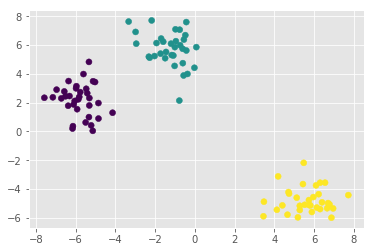

In [8]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [9]:
def check_method(method, X):
    method.fit(X)
    for centroid in method.centroids:
        plt.scatter(centroid[0], centroid[1], s=500)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

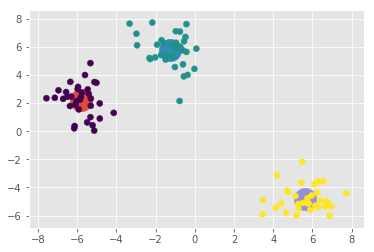

In [57]:
## Работоспособность MyKmeans
check_method(MyKmeans(k=3, random_state=42), X)

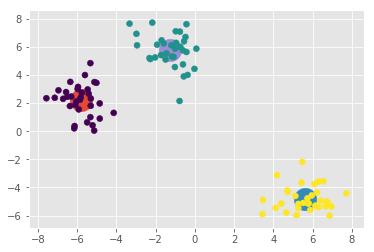

In [16]:
## Работоспособность MyKmeans++
check_method(MyKmeans(k=3, init='k-means'), X)

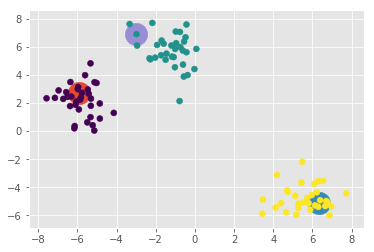

In [13]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
check_method(MiniBatchKMeans(k=3, random_state=42, batch_size = 10), X)

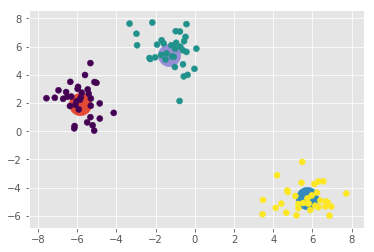

In [17]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
check_method(MiniBatchKMeans(k=3, init='k-means', batch_size = 10), X)

In [11]:
from sklearn.cluster import KMeans

In [64]:
%%time
## Время выполнения алгоритма Kmeans из sklearn
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

CPU times: user 33 ms, sys: 12 µs, total: 33 ms
Wall time: 32.7 ms


In [65]:
%%time
## Время выполнения алгоритма MyKmeans
mykmeans = MyKmeans(k=3, random_state=42)
mykmeans.fit(X)

CPU times: user 46.7 ms, sys: 0 ns, total: 46.7 ms
Wall time: 47.1 ms


In [66]:
%%time
## Время выполнения алгоритма MyKmeans++
mykmeans = MyKmeans(k=3, random_state=42, init = 'k_means')
mykmeans.fit(X)

CPU times: user 35.1 ms, sys: 38 µs, total: 35.1 ms
Wall time: 36.1 ms


In [67]:
%%time
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
mykmeans = MiniBatchKMeans(k=3, random_state=42, batch_size = 10)
mykmeans.fit(X)

CPU times: user 48.2 ms, sys: 7.94 ms, total: 56.1 ms
Wall time: 51.1 ms


In [68]:
%%time
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
mykmeans = MiniBatchKMeans(k=3, random_state=42, batch_size = 10, init = 'k_means')
mykmeans.fit(X)

CPU times: user 28.7 ms, sys: 54 µs, total: 28.8 ms
Wall time: 34.1 ms


In [ ]:
from timeit import default_timer

sizes = np.linspace(10, 10000, 10, dtype=int)
methods = [(KMeans(n_clusters=3), 'sklearn KMeans'),
          (MyKmeans(k=3, random_state=42), 'MyKmeans'),
          (MyKmeans(k=3, random_state=42,
                    init='k-means'), 'MyKmeans++'),
          (MiniBatchKMeans(k=3, random_state=42, 
                           batch_size=10), 'MiniBatchKMeans'),
          (MiniBatchKMeans(k=3, random_state=42,
                           init='k-means', batch_size=10), 
                           'MiniBatchKMeans++')]
time = np.empty((len(methods), sizes.shape[0]))

for a, k in enumerate(sizes):
    X, y = make_blobs(n_samples=k, n_features=2, centers=3,
                      cluster_std=1, shuffle=True, random_state=42)

    for b, method in enumerate(methods):
        time0 = default_timer()
        method[0].fit(X)
        time[b][a] = default_timer() - time0

for i, method in enumerate(methods):
    plt.plot(sizes, time[i], label=method[1])

plt.xlabel('Количество сэмплов')
plt.ylabel('Время работы')
plt.legend()
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [20]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head().T

,0,1,2,3,4
gradyear,2006,2006,2006,2006,2006
gender,M,F,M,F,NaN
age,18.982,18.801,18.335,18.875,18.995
friends,7,0,69,0,10
basketball,0,0,0,0,0
football,0,1,1,0,0
soccer,0,0,0,0,0
softball,0,0,0,0,0
volleyball,0,0,0,0,0
swimming,0,0,0,0,0


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [18]:
from sklearn.preprocessing import StandardScaler

In [82]:
df = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1)
X = np.array(df)
scaler = StandardScaler()
X = scaler.fit_transform(X)
df.isnull().sum().sum()

/home/maria/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0

In [109]:
claster_number = 9
headers = df.dtypes.index

def get_clasters(model, X):
    for i in range(claster_number):
        vector = np.zeros(X.shape[1])
        counter = 0
        for j in range(model.labels.shape[0]):
            if i == model.labels[j]:
                vector+=X[i]
                counter+=1
        if counter != 0:
            print("claster", i, "(count =", counter, ") :")
            sort = np.argsort(vector)[:7]
            for k in sort:
                print(headers[k], end = ', ')
            print()

In [110]:
## MyKMeans
mykmeans = MyKmeans(k=claster_number, random_state=42)
mykmeans.fit(X)
get_clasters(mykmeans, X)

claster 0 (count = 1766 ) :
music, shopping, cute, hair, mall, football, god, 
claster 1 (count = 13921 ) :
shopping, dance, basketball, clothes, church, sports, die, 
claster 2 (count = 2199 ) :
shopping, cute, hair, mall, dance, god, rock, 
claster 3 (count = 1799 ) :
music, shopping, hair, mall, dance, football, god, 
claster 4 (count = 4625 ) :
cute, mall, football, rock, basketball, clothes, church, 
claster 5 (count = 3795 ) :
cute, hair, mall, dance, football, god, rock, 
claster 6 (count = 470 ) :
music, shopping, cute, hair, dance, football, god, 
claster 7 (count = 850 ) :
shopping, cute, hair, mall, dance, football, god, 
claster 8 (count = 575 ) :
music, shopping, cute, hair, mall, dance, football, 


In [111]:
## MyKMeans++
mykmeans = MyKmeans(k=claster_number, init = 'k_means')
mykmeans.fit(X)
get_clasters(mykmeans, X)

claster 0 (count = 1172 ) :
music, shopping, cute, hair, mall, football, god, 
claster 1 (count = 11417 ) :
shopping, dance, basketball, clothes, church, sports, die, 
claster 2 (count = 1115 ) :
shopping, cute, hair, mall, dance, god, rock, 
claster 3 (count = 1442 ) :
music, shopping, hair, mall, dance, football, god, 
claster 4 (count = 2336 ) :
cute, mall, football, rock, basketball, clothes, church, 
claster 5 (count = 2320 ) :
cute, hair, mall, dance, football, god, rock, 
claster 6 (count = 2779 ) :
music, shopping, cute, hair, dance, football, god, 
claster 7 (count = 3718 ) :
shopping, cute, hair, mall, dance, football, god, 
claster 8 (count = 3701 ) :
music, shopping, cute, hair, mall, dance, football, 


In [112]:
## MyKMeans с MiniBatchMyKMeans
mykmeans = MiniBatchKMeans(k=claster_number, random_state=42)
mykmeans.fit(X)
get_clasters(mykmeans, X)

claster 0 (count = 1172 ) :
music, shopping, cute, hair, mall, football, god, 
claster 1 (count = 11417 ) :
shopping, dance, basketball, clothes, church, sports, die, 
claster 2 (count = 1115 ) :
shopping, cute, hair, mall, dance, god, rock, 
claster 3 (count = 1442 ) :
music, shopping, hair, mall, dance, football, god, 
claster 4 (count = 2336 ) :
cute, mall, football, rock, basketball, clothes, church, 
claster 5 (count = 2320 ) :
cute, hair, mall, dance, football, god, rock, 
claster 6 (count = 2779 ) :
music, shopping, cute, hair, dance, football, god, 
claster 7 (count = 3718 ) :
shopping, cute, hair, mall, dance, football, god, 
claster 8 (count = 3701 ) :
music, shopping, cute, hair, mall, dance, football, 


In [113]:
## MyKMeans++ с MiniBatchMyKMeans
mykmeans = MiniBatchKMeans(k=claster_number, init = 'k_means', batch_size = 10)
mykmeans.fit(X)
get_clasters(mykmeans, X)

claster 0 (count = 841 ) :
music, shopping, cute, hair, mall, football, god, 
claster 1 (count = 19664 ) :
shopping, dance, basketball, clothes, church, sports, die, 
claster 2 (count = 581 ) :
shopping, cute, hair, mall, dance, god, rock, 
claster 3 (count = 922 ) :
music, shopping, hair, mall, dance, football, god, 
claster 4 (count = 1685 ) :
cute, mall, football, rock, basketball, clothes, church, 
claster 5 (count = 1927 ) :
cute, hair, mall, dance, football, god, rock, 
claster 6 (count = 1119 ) :
music, shopping, cute, hair, dance, football, god, 
claster 7 (count = 878 ) :
shopping, cute, hair, mall, dance, football, god, 
claster 8 (count = 2383 ) :
music, shopping, cute, hair, mall, dance, football, 


## Вывод
MiniBatchKMeans прекрасен. Он работет быстрее стандартной реализации благодаря тому. что проходится не по всей выборке, и сравним по точности с дефолтными результатами из-за удачной инициализации центройдов 